In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io, transform
from pathlib import Path
import ast
import cv2

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
plt.ion()

In [4]:
df = pd.read_csv("../input/train_folds.csv")
df.head()

Unnamed: 0                                 path  int_nr_COTS annotations  \
0           0  ../input/train_images/video_0/0.jpg            0          []   
1           1  ../input/train_images/video_0/1.jpg            0          []   
2           2  ../input/train_images/video_0/2.jpg            0          []   
3           3  ../input/train_images/video_0/3.jpg            0          []   
4           4  ../input/train_images/video_0/4.jpg            0          []   

   kfold  
0    0.0  
1    0.0  
2    0.0  
3    0.0  
4    0.0

500 folds, each containing 47 samples

In [5]:
# abs path
sample = Path(df.iloc[1]["path"]).resolve()
# Image loading skio
sample_img = io.imread(sample)
for box in np.array(ast.literal_eval(df.iloc[16]["annotations"])):
    np_vals = np.array(list(box.values()))
    print(np_vals.astype("float32"))

[559. 213.  50.  32.]


In [6]:
class TorchDataset(Dataset):
    """Custom Torch Dataset Class to load up and serve samples"""
    def __init__(self, dataframe, transform=None):
        """
        Params: 
        `dataframe` of image path and annotations
        `transforms` where applicable
        """
        self.df = dataframe
        self.transform = transform

    def __getitem__(self, idx):
        """
        Return a single sample by given idx (index)
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        ## Image Parsing
        # abs path for image sample
        img_path = Path(df.iloc[idx]["path"]).resolve()
        # Read image as numpy array
        img_array = io.imread(img_path)

        ## Parsing Bounding Boxes
        # Important: 20 has been specified as max number of bounding boxes per sample
        # so as to avoid variable tensor shapes later on during the dataloading process
        # this acts like padding and keeps tensor shapes constant.
        # A more optimal way to pad is perhaps possible
        boxes = np.zeros(shape=(20, 4))
        # Parse box string
        boxes_obj = ast.literal_eval(df.iloc[idx]["annotations"])
        # Append as np.float32 array
        for i, box in enumerate(boxes_obj):
            box_as_list = np.array(list(box.values()))
            boxes[i] = box_as_list.astype("float32")
        
        sample = dict(image = img_array, boxes=np.array(boxes))

        # Apply transforms as necessary
        if self.transform:
            sample = self.transform(sample)

        return sample

    def __len__(self):
        # Return total iterable dataset size
        return len(self.df)


In [7]:
len(df)

23501

In [8]:
dataset = TorchDataset(dataframe=df)

In [9]:
class ToTensor(object):
    def __call__(self, sample):
        image, boxes = sample["image"], sample["boxes"]
        # Transpose color axis into Pytorch Conv2D friendly format
        # (1280, 720, 3) -> (3, 1280, 720)
        # H x W x C -> C x H x W
        image = image.transpose((2, 0, 1))
        # Return transformed image and leave boxes untouched
        return {
            "image": torch.from_numpy(image),
            "boxes": torch.from_numpy(boxes)
        }

In [10]:
# Transform the dataset into pytorch friendly image arrays (3, h, w)
transformed_dataset = TorchDataset(dataframe=df, transform=transforms.Compose([ToTensor()]))

In [11]:
transformed_dataset[16]["image"].shape, transformed_dataset[16]["boxes"].shape

(torch.Size([3, 720, 1280]), torch.Size([20, 4]))

In [12]:
dataloader = DataLoader(transformed_dataset, batch_size=4, shuffle=False)

In [111]:
# def plot_images(images, n=4):
#     fig, ax = plt.subplots(figsize=(15, 15))
#     ax.set_xticks([]); ax.set_yticks([])
#     grid = utils.make_grid(images.detach()[:n], nrow=2)
#     ax.imshow(grid)

def show_batch(images, n=4):
    """Visualize a batch of samples"""
    fig, ax = plt.subplots(figsize=(30, 30))
    ax.set_xticks([]); ax.set_yticks([])
    grid = utils.make_grid(images.permute(0, 3, 1, 2), nrow=2)
    ax.imshow(grid.permute(1, 2, 0))

In [112]:
def plot_boxes(batch):
    images, boxes = batch["image"], batch["boxes"] 
    plotted = []

    for i, image in enumerate(images):
        img = image.permute(1, 2, 0).numpy().astype(np.uint8).copy()
        for box in boxes[i]:
            x, y, w, h = box.numpy().astype(int)
            if x != 0:
                img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        plotted.append(img)
    return torch.Tensor(plotted)

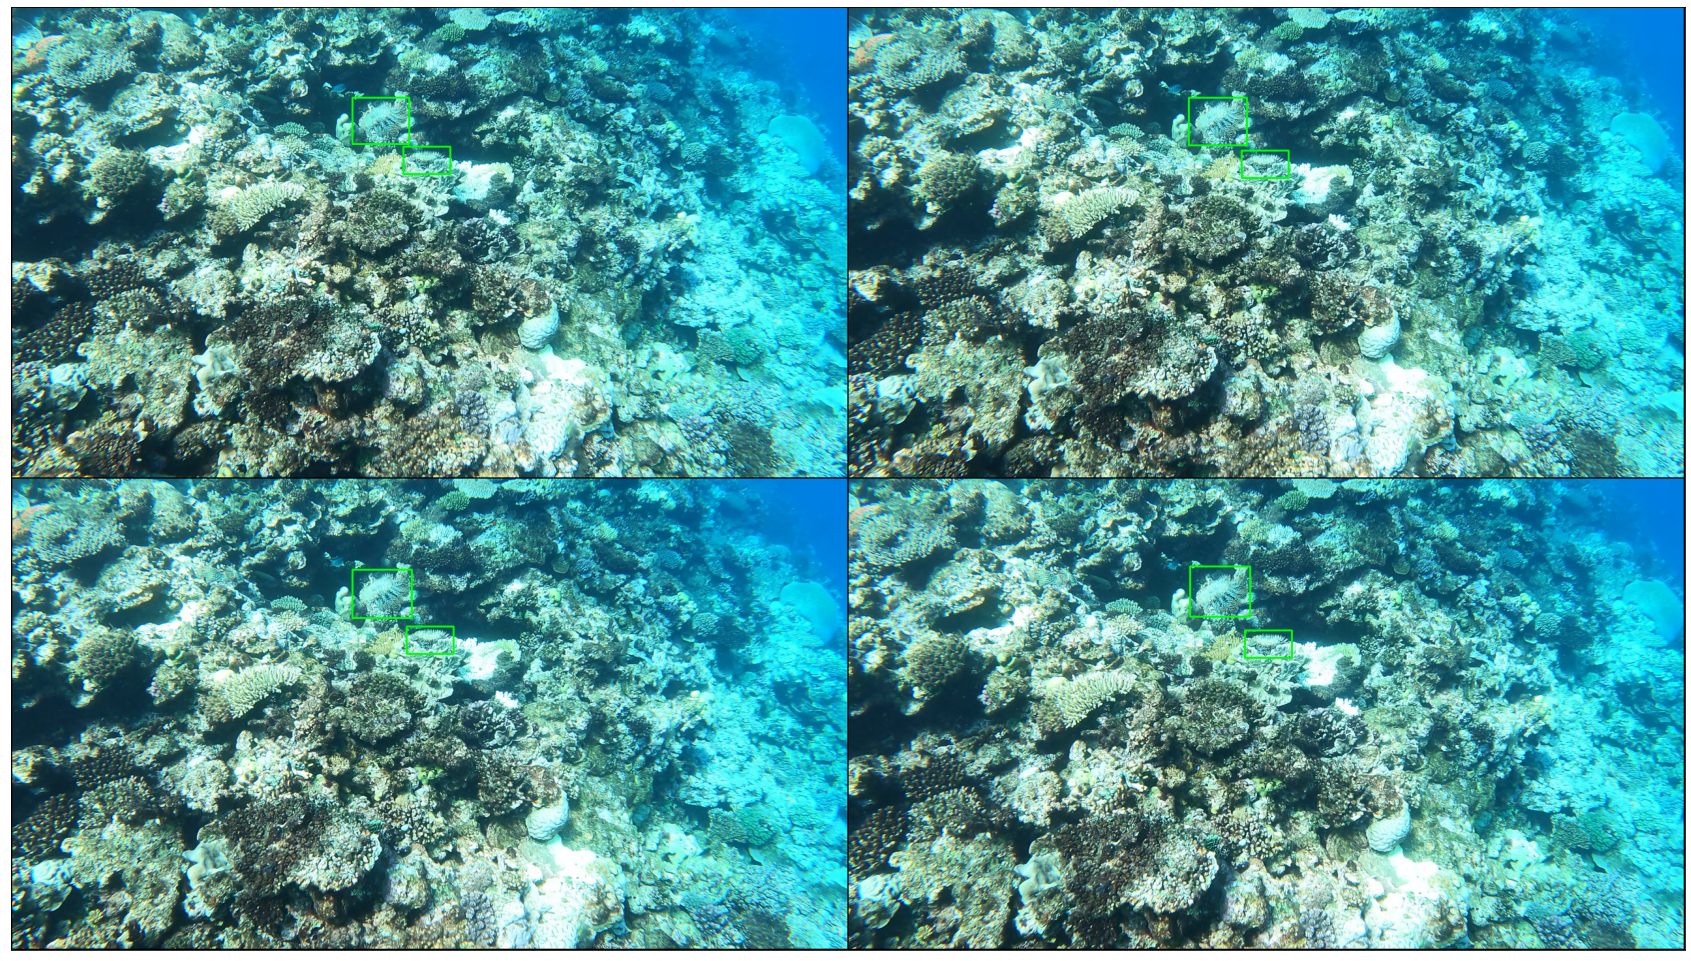

In [114]:
for i, batch in enumerate(dataloader):
    if i == 10:
        plotted_images = plot_boxes(batch)
        plotted_images -= plotted_images.min()
        plotted_images /= plotted_images.max()
        show_batch(plotted_images)
        break